In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import superscreen as sc
from superscreen.geometry import box, circle, close_curve, rotate

ureg = sc.ureg

import sys
sys.path.insert(0, "..")
import squids

In [2]:
print(sc.__version__)

0.8.1


## Functions for calculating the field from a 1D current loop

In [3]:
def biot_savart(
    eval_positions: np.ndarray,
    *,
    current_positions: np.ndarray,
    current_vectors: np.ndarray,
    currents: np.ndarray,
) -> np.ndarray:
    """Calculates the vector magnetic field [Bx, By, Bx] at ``eval_positions``
    due to a discrete set of 1D current elements.

    Input units are meters and Amperes, output units are Tesla.

    Args:
        eval_positions: Shape (n, 3) array of (x, y, z) positions at which to
            evaluate the field.
        current_positions: Shape (m, 3) array of (x, y, z) positions for the
            current elements.
        current_vectors: Shape (m, 3) array of (dx, dy, dy) distance vectors
            indicating the direction and length of the current elements.
        currents: Shape (m, ) or (m, 1) array of current magnitudes for each
            current element.

    Returns:
        Shape (n, 3) pint.Quantity array of the vector magnetic field
        at ``eval_positions``.
    """
    eval_positions = np.atleast_2d(eval_positions)
    current_positions = np.atleast_2d(current_positions)
    current_vectors = np.atleast_2d(current_vectors)
    currents = np.atleast_2d(currents)
    assert eval_positions.shape[-1] == 3
    assert current_positions.shape[-1] == 3
    assert current_vectors.shape[-1] == 3
    assert currents.shape[-1] == 1

    dx = np.subtract.outer(eval_positions[:, 0], current_positions[:, 0])
    dy = np.subtract.outer(eval_positions[:, 1], current_positions[:, 1])
    dz = np.subtract.outer(eval_positions[:, 2], current_positions[:, 2])
    rprime = np.stack([dx, dy, dz], axis=-1)
    denom = (np.linalg.norm(rprime, axis=-1) ** 3)[:, :, np.newaxis]
    integrand = np.cross(current_vectors, rprime) / denom
    integral = np.einsum("jk,ijk -> ik", currents, integrand)
    mu_0 = ureg("mu_0").to_base_units().magnitude
    return mu_0 / (4 * np.pi) * integral * ureg("tesla")

In [4]:
def current_loop_field(
    positions: np.ndarray,
    *,
    loop_center =(0, 0, 0),
    loop_radius: float = 1e-6,
    current: float = 1e-3,
    num_segments: int = 101,
    length_units: str = "um",
    current_units: str = "uA",
):
    """Calculates the vector magnetic field [Bx, By, Bz] at ``positions``
    due to a 1D current loop, in units of tesla.

    Args:
        positions: Shape (n, 3) array of (x, y, z) positions at which to
            evaluate the vector potential.
        loop_center: (x, y, z) coordinates of the current loop center.
        loop_radius: radius of the current loop.
        current: Magnitude of the current flowing in the loop.
        num_segments: Number of current elements used to model the loop.
        length_units: A string specifying the length units.
        current_units: A string specifying the current units.

    Returns:
        Shape (n, 3) array of the magnetic field [Bx, By, Bz] at ``positions``.
    """
    to_meter = ureg(length_units).to("m").magnitude
    to_amp = ureg(current_units).to("A").magnitude
    positions = np.atleast_2d(positions) * to_meter
    loop_center = np.atleast_2d(loop_center) * to_meter
    loop_radius = loop_radius * to_meter
    current = current * to_amp
    # Create loop positions
    thetas = np.linspace(0, 2 * np.pi, num_segments)
    circ = np.array([np.cos(thetas), np.sin(thetas), np.zeros_like(thetas)]).T
    loop = loop_radius * circ + loop_center
    dloop = np.diff(loop, axis=0)
    loop = loop[:-1]
    return biot_savart(
        positions,
        current_positions=loop,
        current_vectors=dloop,
        currents=current,
    ).to("tesla")

## Define the SQUID

In [5]:
squid_modules = {
    "ibm-small": squids.ibm.small,
    "ibm-medium": squids.ibm.medium,
    "ibm-large": squids.ibm.large,
    "ibm-xlarge": squids.ibm.xlarge,
    "huber": squids.huber,
    "hypres-small": squids.hypres.small,
}

In [6]:
squid_with_field_coil = squid_modules["ibm-xlarge"].make_squid()

### Remove the BE wiring layer and the field coil/field coil shield.

In [7]:
layers = [squid_with_field_coil.layers[name] for name in ["BE", "W1"]]
films = [squid_with_field_coil.films[name] for name in ["fc", "fc_shield"]]
holes = [squid_with_field_coil.holes[name] for name in ["fc_center"]]
abstract_regions = [squid_with_field_coil.abstract_regions["bounding_box"]]

squid = sc.Device(
    "ibm_3um",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units="um",
)
squid = squid.translate(dz=-squid.layers["BE"].z0)
# "float32" uses less memory than the default "float64"
squid.dtype = "float32"

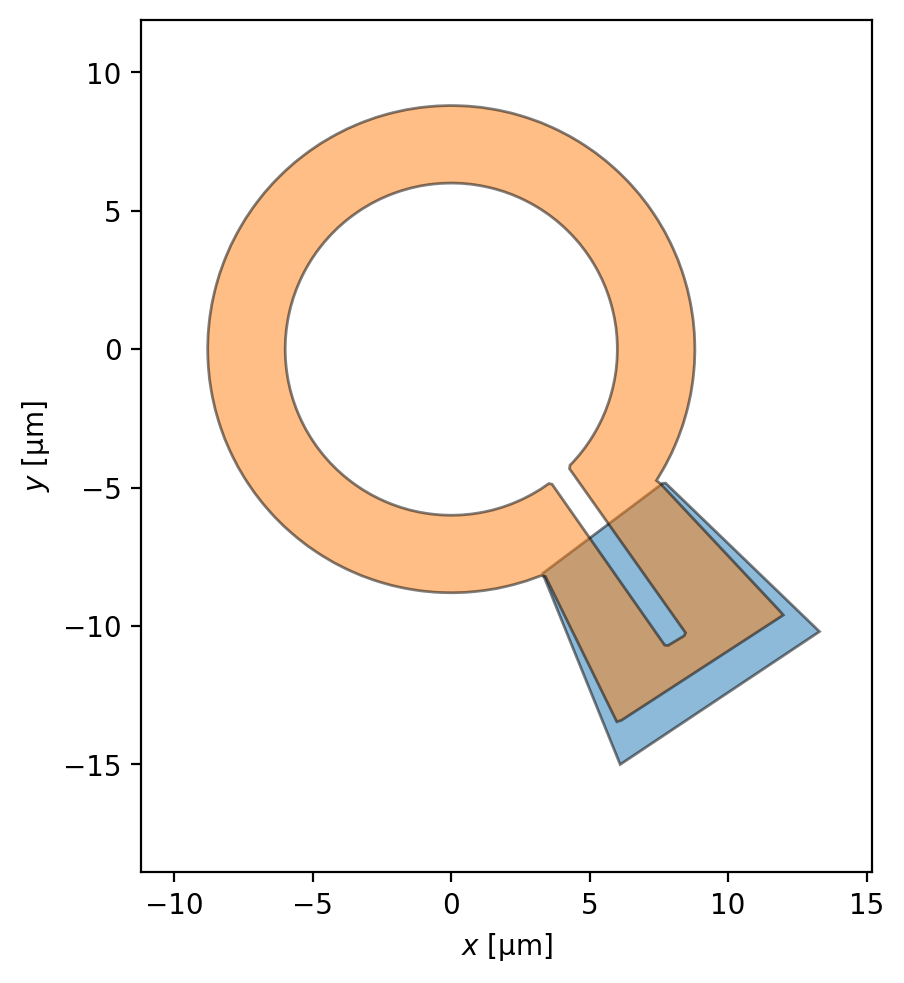

In [8]:
_ = squid.draw(exclude="bounding_box")

In [9]:
squid.make_mesh(min_points=6000, smooth=100)

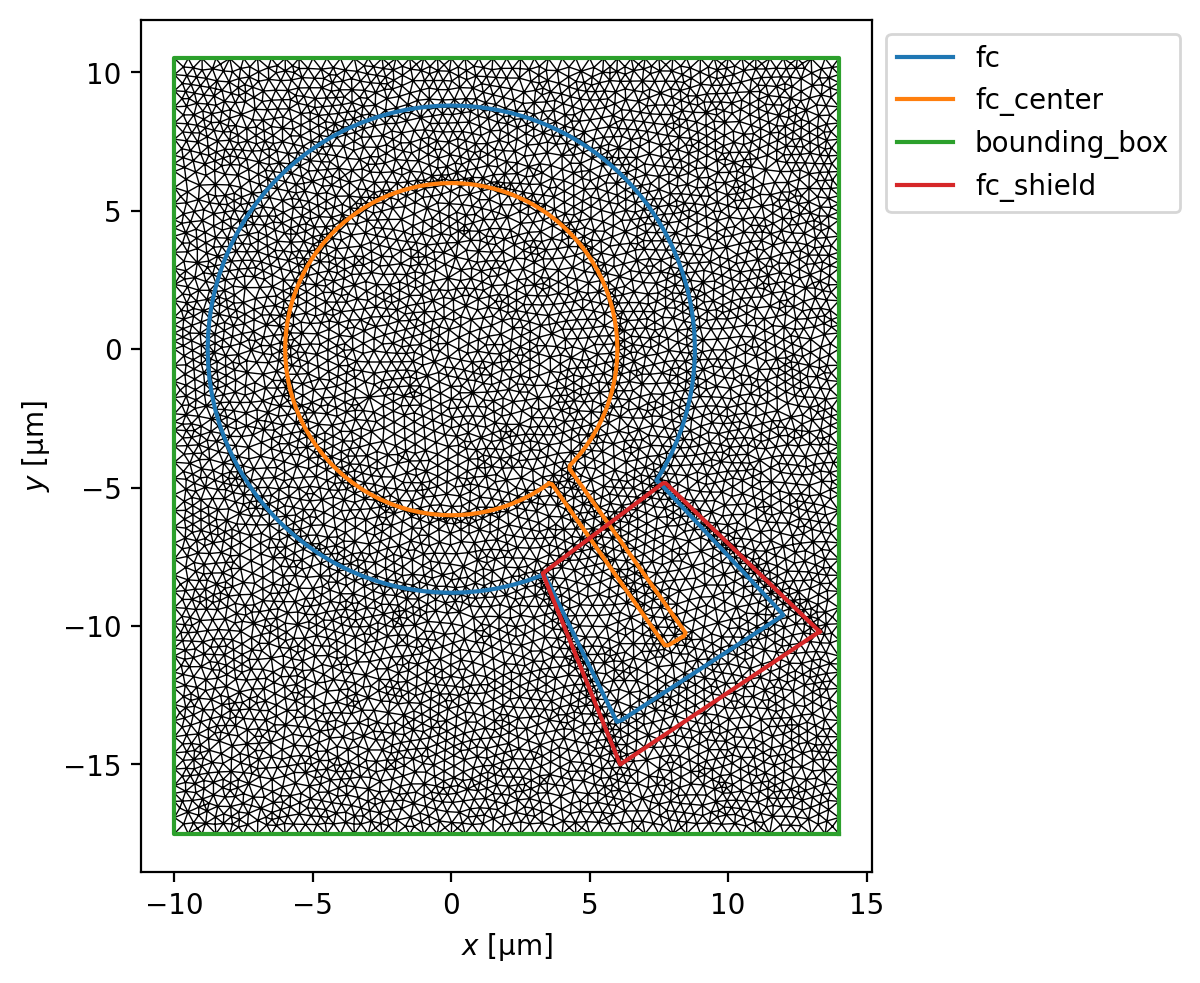

In [10]:
_ = squid.plot(mesh=True)

## Calculate the field from the FC using SuperScreen

In [11]:
solutions = sc.solve(
    squid,
    circulating_currents=dict(fc_center="1 mA"),
    field_units="mT",
    current_units="mA",
    iterations=10,
)

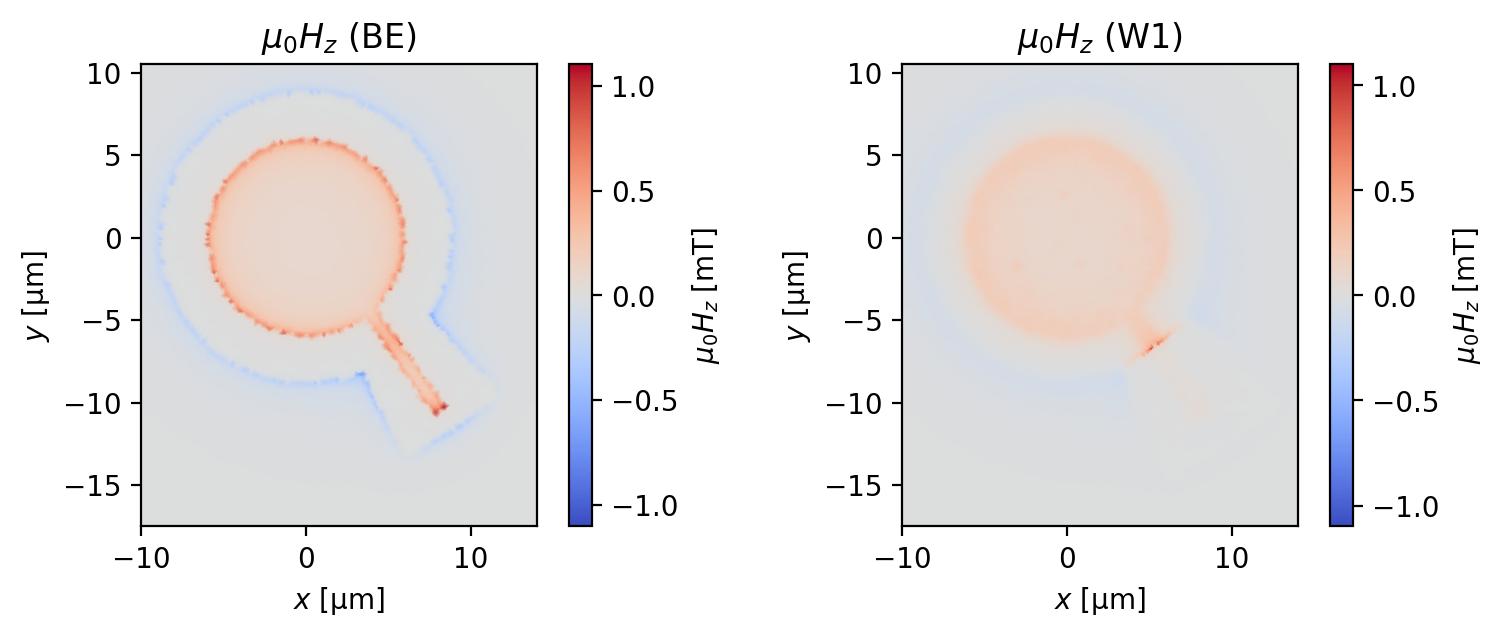

In [12]:
fig, axes = solutions[-1].plot_fields(
    figsize=(9, 3),
    symmetric_color_scale=True,
    cmap="coolwarm",
)

### Evaluate the field a given distance below the field coil

Here `squid_height` is defined as the vertical distance between the field coil and the plane at which the field is evaluated, i.e., `squid_height = 1` means that we evaluate the FC field at a plane 1 micron below the FC.

Because of the finite width of the field coil, the fit is not very good for SQUID heights that are comparable to the width of the field coil.

In [13]:
squid_height = 1 # um

In [14]:
if squid_height == 0:
    xs = np.linspace(-12, 12, 501)
else:
    xs = np.linspace(-20, 20, 501)

ys = np.zeros_like(xs)
zs = -squid_height * np.ones_like(xs)[:, np.newaxis]
eval_coords = np.concatenate([rotate(np.array([xs, ys]).T, 35), zs], axis=1)

In [15]:
distance_along_cut = np.cumsum(np.linalg.norm(np.diff(eval_coords, axis=0), axis=1))
distance_along_cut = np.concatenate([[0], distance_along_cut])

if squid_height == 0:
    field_along_cut = solutions[-1].interp_fields(eval_coords[:, :2], units="mT", with_units=False)["BE"]
else:
    field_along_cut = solutions[-1].field_at_position(eval_coords, units="mT", with_units=False)

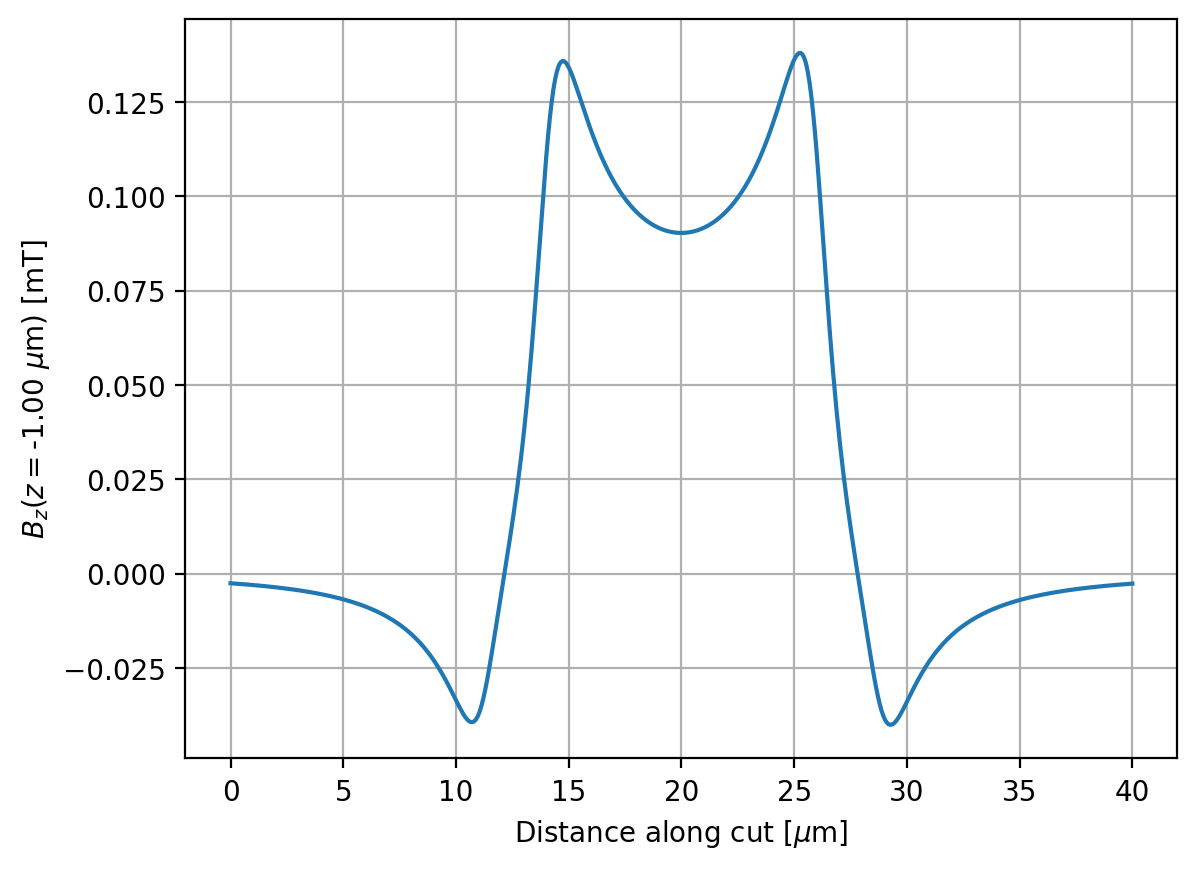

In [16]:
fig, ax = plt.subplots()
ax.plot(distance_along_cut, field_along_cut)
ax.set_xlabel("Distance along cut [$\\mu$m]")
ax.set_ylabel(f"$B_z$($z=${-squid_height:.2f} $\\mu$m) [mT]")
ax.grid(True)

## Fit the simulation to the field from a 1D circular loop

In [17]:
def loop_model(eval_positions, radius):
    B = current_loop_field(
        eval_positions,
        loop_radius=radius,
        loop_center=(0, 0, 0),
        num_segments=201,
        current=1,
        current_units="mA",
        length_units="um",
    )
    return B[:, 2].to("mT").magnitude

In [18]:
popt, pcov = curve_fit(
    loop_model,
    eval_coords,
    field_along_cut,
    p0=[6],
)
r_eff = popt[0]
fit_err = np.sqrt(pcov[0, 0])

Text(0.5, 1.0, 'Best fit: $r_{eff}=({6.870}\\pm{0.018})$ $\\mu$m')

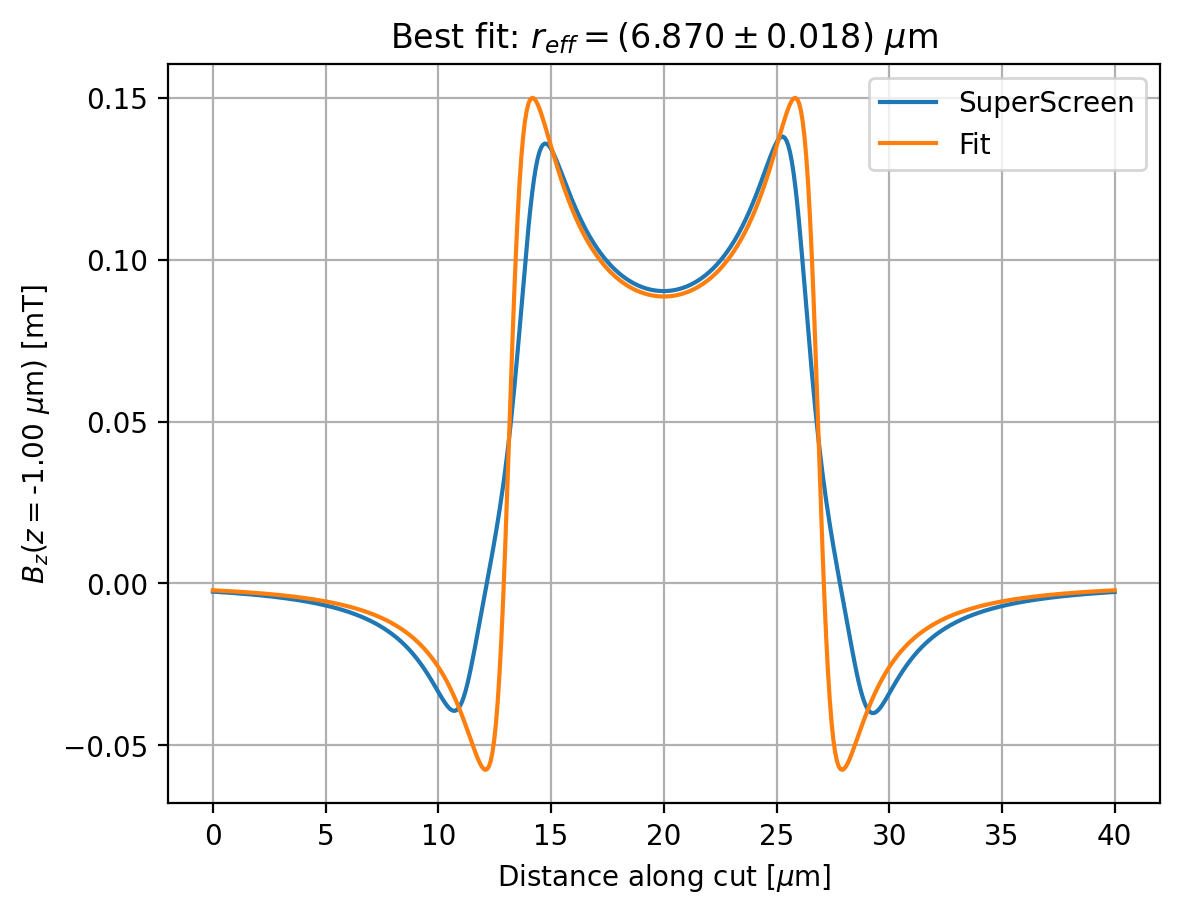

In [19]:
fig, ax = plt.subplots()
ax.plot(distance_along_cut, field_along_cut, label="SuperScreen")
ax.set_xlabel("Distance along cut [$\\mu$m]")
ax.set_ylabel(f"$B_z$($z=${-squid_height:.2f} $\\mu$m) [mT]")
ax.plot(distance_along_cut, loop_model(eval_coords, r_eff), label="Fit")
ax.grid(True)
ax.legend(loc=0)
ax.set_title(f"Best fit: $r_{{eff}}=({{{r_eff:.3f}}}\\pm{{{fit_err:.3f}}})$ $\\mu$m")

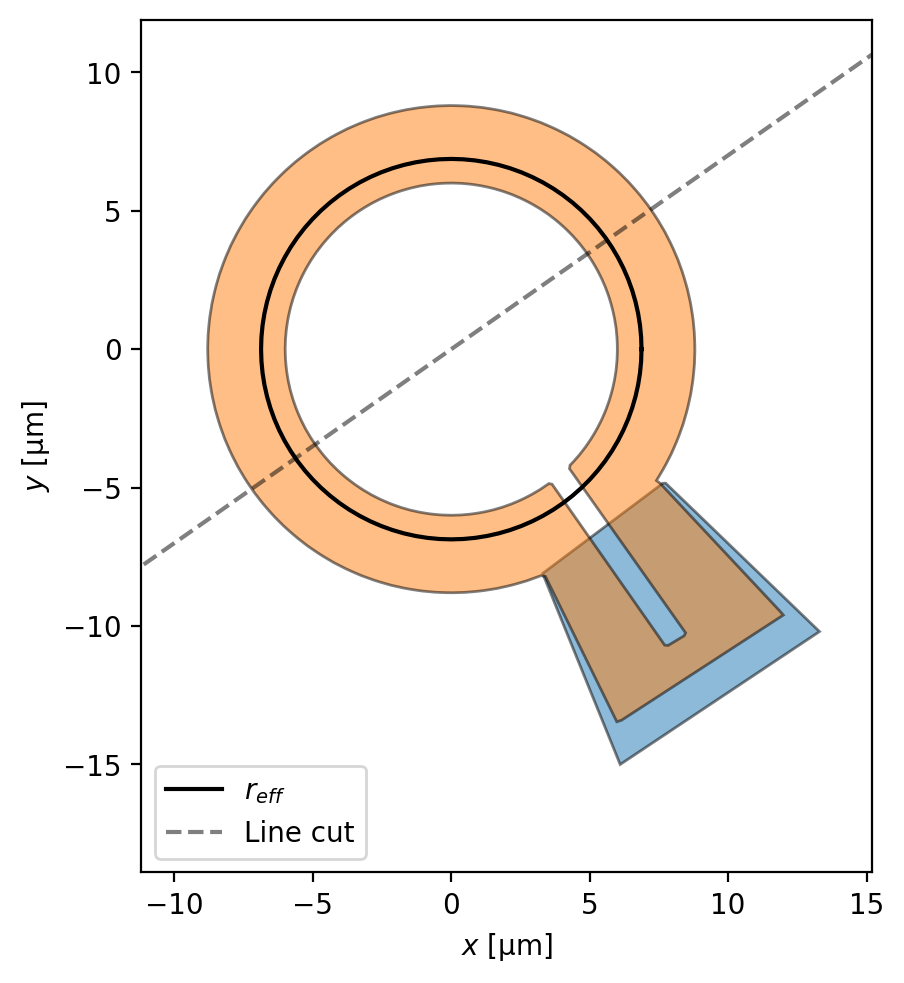

In [20]:
fig, ax = squid.draw(exclude=["bounding_box"])
ax.plot(*close_curve(circle(r_eff)).T, "k", label="$r_{eff}$")
ax.plot(*eval_coords[:, :2].T, "k--", alpha=0.5, label="Line cut")
ax.legend(loc=0)

In [21]:
sc.version_table()

Software,Version
SuperScreen,0.8.1
Numpy,1.23.3
SciPy,1.9.1
matplotlib,3.6.0
ray,2.0.0
jax,0.3.18
IPython,8.5.0
Python,"3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) [Clang 13.0.1 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 10, Logical: 10"
